## Tesla Stock Price Prediction, 365 Days
### Second Semester Capstone

This is the same as the "Semester Start" notebook, but now I'm making a 365 day prediction. I've also added a section for finding the quarterly maximums and adding those maximums to the prediction chart.  This is a prediction of Tesla stock price. I use Trump and Elon Musk tweet data as part of the prediction. I did some low effort sentiment analysis using the nlkt Python library (nltk = Natural Language Toolkit) and the VADER pre-trained sentiment analysis tool. I also make my own attempt at analysis of the tweets by seeing whether they contain some Tesla-related keywords. In addition I use Google Trends data for "Tesla" as another feature.

In [1]:
import nltk
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer
from statistics import mean
sia = SentimentIntensityAnalyzer()

# These are the functions for the sentiment analysis. 
# is_positive uses the pre-made SentimentIntensityAnalyzer that's a part of the nltk library.
def is_positive(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    scores = [sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(tweet)]
    return mean(scores) > 0

# contains_tesla returns positive if the tweet contains any of the words or phrases in the "search" list.
def contains_tesla(tweet: str) -> bool:
    search = ("tesla", "tsla", "cybertruck", "model s", "model x", "model 3", "model y", "electric car", "electric cars")
    return any(word in tweet.lower() for word in search)

In [3]:
df_trump = pd.read_csv("Data/trump_tweets.csv", parse_dates = ['date'], index_col=7)
# Applying the sentiment analysis functions to the trump data
df_trump["Trump Positive Sentiment"] = df_trump.apply(lambda row: is_positive(row["text"]), axis = 1)
df_trump["Trump Contains Tesla"] = df_trump.apply(lambda row: contains_tesla(row["text"]), axis=1)
print(df_trump.shape)
df_trump.head()

(56571, 10)


,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged,Trump Positive Sentiment,Trump Contains Tesla
date,,,,,,,,,,
2009-05-04 18:54:00,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,f,True,False
2009-05-05 01:00:00,1.701461e+09,Donald Trump will be appearing on The View tom...,f,f,Twitter Web Client,259,34,f,True,False
2009-05-08 13:38:00,1.737480e+09,Donald Trump reads Top Ten Financial Tips on L...,f,f,Twitter Web Client,37,15,f,True,False
2009-05-08 20:40:00,1.741161e+09,New Blog Post: Celebrity Apprentice Finale and...,f,f,Twitter Web Client,29,11,f,False,False
2009-05-12 14:07:00,1.773561e+09,"""""""My persona will never be that of a wallflow...",f,f,Twitter Web Client,1877,1321,f,False,False


In [4]:
df_musk = pd.read_csv("Data/musk_2021.csv", parse_dates = ['date'], index_col=0)
# The csv is indexed by id, we want it indexed by date
df_musk.set_index("date", inplace=True)
df_musk.sort_index(ascending=True, inplace=True)
df_musk["Musk Positive Sentiment"] = df_musk.apply(lambda row: is_positive(row["tweet"]), axis = 1)
df_musk["Musk Contains Tesla"] = df_musk.apply(lambda row: contains_tesla(row["tweet"]), axis=1)
print(df_musk.shape)
df_musk.head()

(12339, 39)


,id,conversation_id,created_at,timezone,place,tweet,language,hashtags,cashtags,user_id,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Musk Positive Sentiment,Musk Contains Tesla
date,,,,,,,,,,,,,,,,,,,,,
2010-06-04 18:31:57,15434727182,15434727182,1.275676e+12,0,NaN,"Please ignore prior tweets, as that was someon...",en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False
2011-12-01 09:55:11,142179928203460608,142179928203460608,1.322733e+12,0,NaN,Went to Iceland on Sat to ride bumper cars on ...,en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False
2011-12-01 10:29:04,142188458125963264,142188458125963264,1.322735e+12,0,NaN,I made the volume on the Model S http://t.co/...,en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,False,True
2011-12-03 08:20:28,142880871391838208,142880871391838208,1.322900e+12,0,NaN,"Great Voltaire quote, arguably better than Twa...",en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,True,False
2011-12-03 08:22:07,142881284019060736,142881284019060736,1.322901e+12,0,NaN,That was a total non sequitur btw,en,[],[],44196397,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,False,False


In [5]:
# Tesla stock data from Yahoo Finance
df_tsla = pd.read_csv("Data/TSLA.csv", parse_dates=['Date'], index_col=0)
print(df_tsla.shape)
df_tsla.head()

(2856, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500


In [6]:
# Google Trends Data for the keyword "Tesla"
# Explanation of columns copied from dataDownload.py:
"""
    Contains 4 columns.
            The column named after the word argument contains the daily search
            volume already scaled and comparable through time.
            The column f'{word}_unscaled' is the original daily data fetched
            month by month, and it is not comparable across different months
            (but is comparable within a month).
            The column f'{word}_monthly' contains the original monthly data
            fetched at once. The values in this column have been backfilled
            so that there are no NaN present.
            The column 'scale' contains the scale used to obtain the scaled
            daily data.
"""
# We only need the "Tesla" column, which is scaled across the various months. Renamed "Tesla Trend" for clarity

df_tslaTrend = pd.read_csv("Data/tslaTrend2.csv", parse_dates=['date'], index_col=0)
print(df_tslaTrend.shape)
df_tslaTrend.drop(columns=['Tesla_unscaled', 'Tesla_monthly', 'isPartial', 'scale'], axis=1, inplace=True)
df_tslaTrend.rename(columns={'Tesla': 'Tesla Trend'}, inplace=True)
df_tslaTrend.head()

(3928, 5)


,Tesla Trend
date,
2010-06-30,NaN
2010-07-01,7.00
2010-07-02,6.09
2010-07-03,1.19
2010-07-04,2.94


# LSTM Application

## Function For Converting Time Series Data For Supervised Learning

In [7]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

### Trimming and merging dataframes

In [8]:
# Aligning Tweet Data with Doge Data
df_musk = df_musk.loc[(df_musk.index >= '2010-06-30')]
# Dropping columns that are not expected to be useful
df_musk = df_musk.drop(columns=[
    'id', 'conversation_id', 'timezone', 'place',
    'language', 'user_id', 'geo', 'source', 'user_rt_id',
    'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
    'translate', 'trans_src', 'trans_dest', 'user_id_str',
    'username', 'name', 'day', 'hour', 'link', 'urls',
    'photos', 'video', 'thumbnail', 'retweet', 'quote_url',
    'search', 'near', 'created_at', 'tweet', 'hashtags',
    'cashtags'
], axis=1)

# Changing by-the-second data to by-the-day data
changed1 = df_musk.groupby([df_musk.index.date]).size().reset_index(name='Musk Tweet Count')
changed2 = df_musk.groupby([df_musk.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_musk = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_musk = df_musk.rename_axis('Date')
df_musk.rename(columns={"nlikes": "Musk Likes", "nreplies": "Musk Replies", "nretweets": "Musk Retweets"}, inplace=True)
df_musk["Musk Negative Sentiment"] = df_musk["Musk Tweet Count"] - df_musk["Musk Positive Sentiment"]
print(df_musk.shape)
df_musk.head(10)

(2004, 7)


,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Musk Positive Sentiment,Musk Contains Tesla,Musk Negative Sentiment
Date,,,,,,,
2011-12-01,2,267,63,24,1,1,1
2011-12-03,2,82,38,31,1,0,1
2011-12-04,1,65,17,9,1,0,0
2011-12-21,7,1330,87,597,5,0,2
2011-12-22,3,1349,132,206,1,1,2
2011-12-24,3,117113,1370,8434,2,0,1
2011-12-26,6,558,102,171,3,0,3
2011-12-27,1,39,13,34,1,0,0
2011-12-28,1,12,7,1,1,0,0


In [9]:
# Aligning Tweet Data with Doge Data
#df_trump = df_trump.loc[(df_trump.index >= '2011-12-01')]
# Dropping ID column since it's not expected to be useful
df_trump = df_trump.drop(columns=['id'], axis=1)

# Changing by-the-second data to by-the-day data
changed1 = df_trump.groupby([df_trump.index.date]).size().reset_index(name='Trump Tweet Count')
changed2 = df_trump.groupby([df_trump.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_trump = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_trump = df_trump.rename_axis('Date')
df_trump.rename(columns={"favorites": "Trump Favorites", "retweets": "Trump Retweets"}, inplace=True)
df_trump["Trump Negative Sentiment"] = df_trump["Trump Tweet Count"] - df_trump["Trump Positive Sentiment"]

print(df_trump.shape)
df_trump.head()

(3500, 6)


,Trump Tweet Count,Trump Favorites,Trump Retweets,Trump Positive Sentiment,Trump Contains Tesla,Trump Negative Sentiment
Date,,,,,,
2009-05-04,1,939,519,1,0,0
2009-05-05,1,259,34,1,0,0
2009-05-08,2,66,26,1,0,1
2009-05-12,2,1902,1347,1,0,1
2009-05-13,1,17,16,1,0,0


In [10]:
# Aligning tsla Data with Tweet Data
df_tsla = df_tsla.loc[(df_tsla.index <= '2021-03-22')]
#df_tsla = df_tsla.loc[(df_tsla.index >= '2011-12-01')]
print(df_tsla.shape)

(2700, 6)


In [11]:
# Merging Two Data Sets Together
df = df_tsla.merge(df_musk, how='outer', left_index=True, right_index=True)
df = df.merge(df_trump, how='outer', left_index=True, right_index=True)
df = df.merge(df_tslaTrend, how='outer', left_index=True, right_index=True)
# As part of the merge we get some NA values, We want to replace those with a value of '0'
df[['Musk Tweet Count', 'Musk Likes', 'Musk Replies', 'Musk Retweets', 'Musk Positive Sentiment', \
        'Musk Contains Tesla', 'Musk Negative Sentiment', 'Trump Tweet Count', 'Trump Favorites', 'Trump Retweets', \
        'Trump Positive Sentiment', 'Trump Contains Tesla', 'Trump Negative Sentiment']] \
    = df[['Musk Tweet Count', 'Musk Likes', 'Musk Replies', 'Musk Retweets', 'Musk Positive Sentiment', \
            'Musk Contains Tesla', 'Musk Negative Sentiment', 'Trump Tweet Count', 'Trump Favorites', 'Trump Retweets', \
            'Trump Positive Sentiment', 'Trump Contains Tesla', 'Trump Negative Sentiment']].fillna(0)

# Rows with NaN values for Open, High, Low, etc will be removed later by the series_to_supervised function
df.head()

,Open,High,Low,Close,Adj Close,Volume,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Musk Positive Sentiment,Musk Contains Tesla,Musk Negative Sentiment,Trump Tweet Count,Trump Favorites,Trump Retweets,Trump Positive Sentiment,Trump Contains Tesla,Trump Negative Sentiment,Tesla Trend
2009-05-04,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,939.0,519.0,1.0,0.0,0.0,NaN
2009-05-05,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,259.0,34.0,1.0,0.0,0.0,NaN
2009-05-08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,66.0,26.0,1.0,0.0,1.0,NaN
2009-05-12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1902.0,1347.0,1.0,0.0,1.0,NaN
2009-05-13,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,16.0,1.0,0.0,0.0,NaN


### Converting Data for Supervised Learning

In [12]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
# We want all variables we're including in the model for t-1 and only the variable we're predicting for time t
reframed.drop(reframed.columns[[39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,22,21,20]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()


(2111, 21)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var4(t)
112,0.001995,0.002071,0.001218,0.001400,0.001400,0.133184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00625,1.954631e-06,0.000011,0.0,0.0,0.011236,0.062500,0.000773
117,0.000869,0.000751,0.000196,0.000070,0.000070,0.110956,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00625,7.329866e-07,0.000019,0.0,0.0,0.011236,0.013105,0.000000
118,0.000059,0.000000,0.000000,0.000000,0.000000,0.111857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.030040,0.000377
119,0.000000,0.000198,0.000136,0.000377,0.000377,0.124842,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.048387,0.000364
123,0.000408,0.000321,0.000465,0.000284,0.000284,0.034265,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.028629,0.000532


## Running Model

In [13]:
values = reframed.values
# split into train, test, and prediction sets
n_predict = 365 # We are predicting 365 days
n_train = floor((len(values) * 0.80)) # 80% of the data is currently used for train
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :] # What's left is used for test
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1688, 1, 20) (1688,) (58, 1, 20) (58,) (365, 1, 20) (365,)


In [14]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.callbacks import Callback

# Unused
"""
class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 0.009 #Assign THR with the value at which you want to stop training.
            if logs.get('loss') <= THR:
                 self.model.stop_training = True
"""

2022-02-03 14:56:53.241266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-03 14:56:53.241324: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-02-03 14:56:58.551311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-03 14:56:58.551378: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-03 14:56:58.551423: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Thomas-Thinkpad): /proc/driver/nvidia/version does not exist
2022-02-03 14:56:58.552207: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
4/4 - 7s - loss: 0.0299 - accuracy: 5.9242e-04 - val_loss: 0.0326 - val_accuracy: 0.0000e+00 - 7s/epoch - 2s/step
Epoch 2/150
4/4 - 0s - loss: 0.0248 - accuracy: 5.9242e-04 - val_loss: 0.0230 - val_accuracy: 0.0000e+00 - 118ms/epoch - 30ms/step
Epoch 3/150
4/4 - 0s - loss: 0.0216 - accuracy: 5.9242e-04 - val_loss: 0.0180 - val_accuracy: 0.0000e+00 - 156ms/epoch - 39ms/step
Epoch 4/150
4/4 - 0s - loss: 0.0196 - accuracy: 5.9242e-04 -

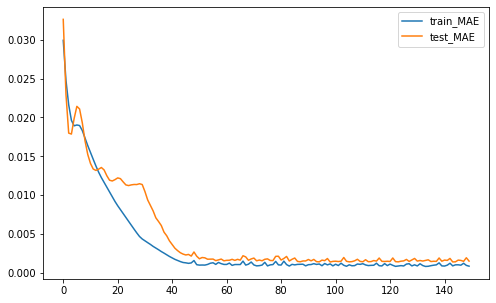

In [15]:
# Design Network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=450, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.show()

### Prediction

In [16]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Metrics

In [17]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(mean(inv_y))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 19.346
Normalized RMSE: 0.072


In [18]:
# Finding the predicted quarterly maximums
dates = df.index.to_numpy()
dates = dates[len(dates)-n_predict:]

maxes = [
    dates[np.argmax(yhat[0:89], axis=0)], 
    dates[np.argmax(yhat[90:179], axis=0)+90], 
    dates[np.argmax(yhat[180:269], axis=0)+180], 
    dates[np.argmax(yhat[270:364], axis=0)+270]
]
maxes_actual = [
    dates[np.argmax(predict_y[0:89], axis=0)], 
    dates[np.argmax(predict_y[90:179], axis=0)+90], 
    dates[np.argmax(predict_y[180:269], axis=0)+180], 
    dates[np.argmax(predict_y[270:364], axis=0)+270]
]

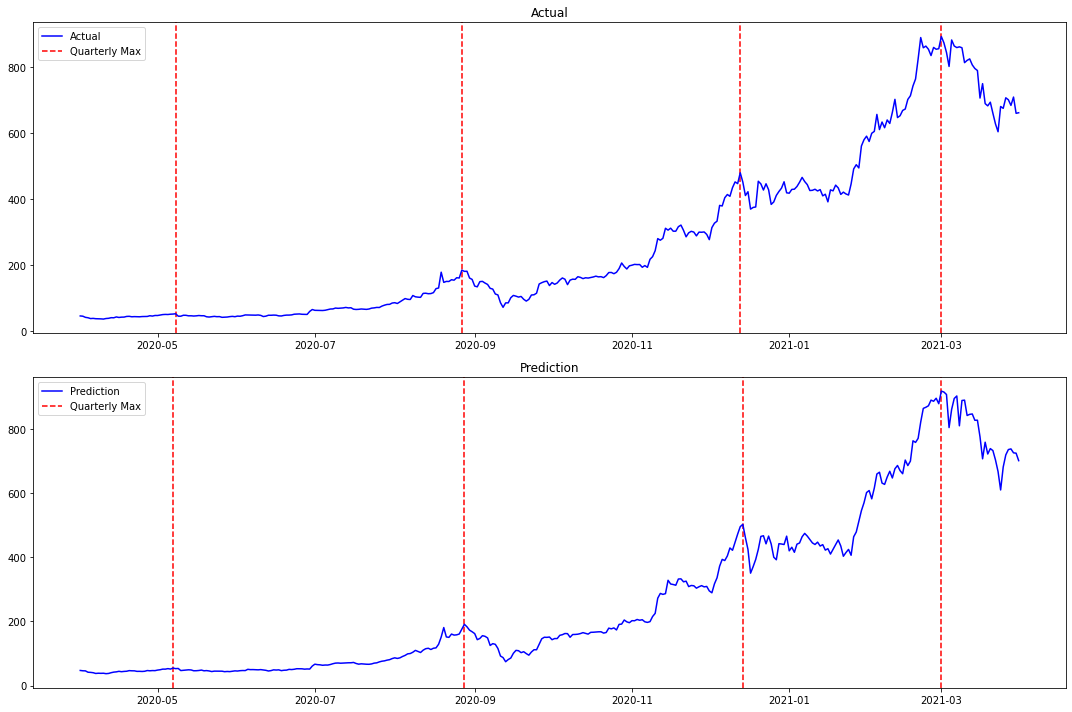

In [19]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(15,10))

pyplot.subplot(2, 1, 1)
pyplot.plot(dates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual")

pyplot.subplot(2, 1, 2)
pyplot.plot(dates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction")

pyplot.tight_layout()
pyplot.show()

In [20]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i][0]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i][0]))
    print("Diff: %s" %abs((maxes_actual[i][0]-maxes[i][0]).astype('timedelta64[D]')))

Q1 Max: 2020-05-07T00:00:00.000000000
Q1 Actual Max: 2020-05-08T00:00:00.000000000
Diff: 1 days
Q2 Max: 2020-08-28T00:00:00.000000000
Q2 Actual Max: 2020-08-27T00:00:00.000000000
Diff: 1 days
Q3 Max: 2020-12-14T00:00:00.000000000
Q3 Actual Max: 2020-12-13T00:00:00.000000000
Diff: 1 days
Q4 Max: 2021-03-01T00:00:00.000000000
Q4 Actual Max: 2021-03-01T00:00:00.000000000
Diff: 0 days


In [21]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
# The "20" here is the number of features in the model
shap_values_2D = shap_values[0].reshape(-1,20)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


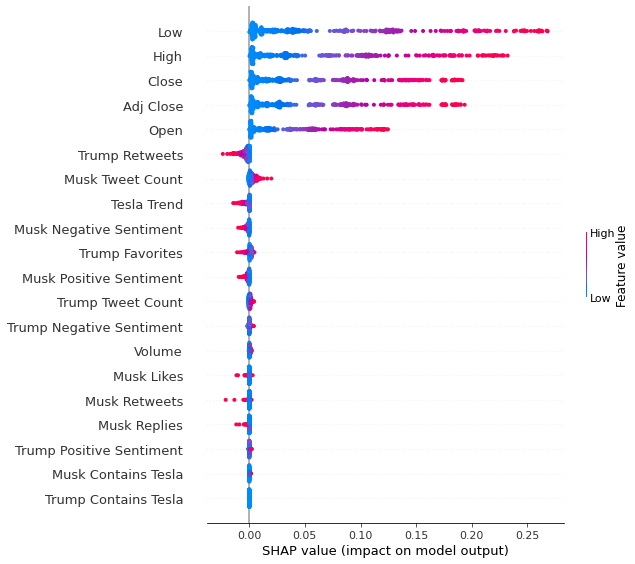

In [22]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)